# TP à rendre 4 descripteurs d'images
Dans ce TP, nous aimerions appliquer une analyse d'image en extrayant les points clés d'une image donnée.
L'objectif de la detection de points d'interet est d'initier des traitement ultérieurs tel que la comparaison d'images entres elles.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
#lecture de l'image
image =cv.imread('image2.png',0)

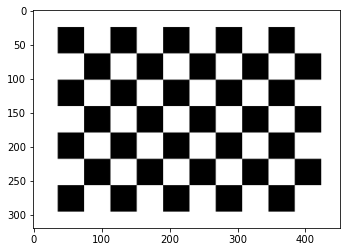

In [3]:
plt.imshow(image,cmap='gray')

# Detection de points avec le detecteur MORAVEC

Définition de paramètres

In [4]:
# paramétres de MORAVEC
S= 2  # Seuil
F= 3  # Taille de la fenêtre
U= [[1,0],[1,1],[0,1],[-1,1],[-1,0],[-1,-1],[0,-1],[1,-1]]# Déplacements

Calcul de la carte de coins (cornerness map)

In [5]:
res = np.ndarray((image.shape[0],image.shape[1],8))
for i in range(2,image.shape[0]-3):
    for j in range(2,image.shape[1]-3):
        n = 0
        fen = image[i-1:i+2][:,j-1:j+2]
        for u,v in U:
            fenuv = image[i+u-1:i+u+2][:,j+v-1:j+v+2]
            res[i][j][n] = ((fenuv-fen)*(fenuv-fen)).sum()
            n=n+1

Minimum de la carte de coins

In [6]:
C = np.ndarray(image.shape)
for i in range(2,image.shape[0]-2):
    for j in range(2,image.shape[1]-2):
        C[i][j] = np.min(res[i][j])

Appel des fonctions pour calcul de points d'interêt

In [7]:
pointsInteret = C>S

Affichage de l'image résultante, colorer chaque point d'interêt

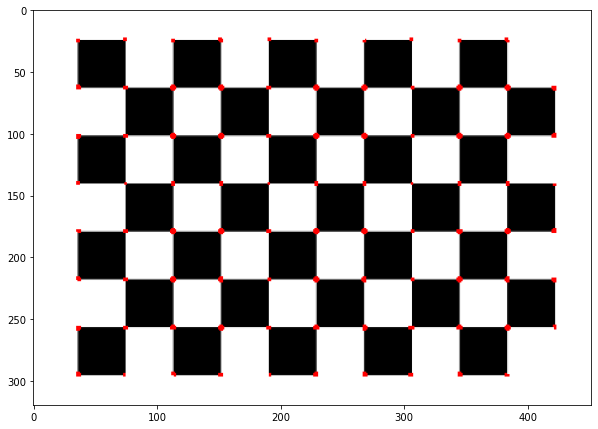

In [9]:
imageCol =cv.imread('image2.png')
imageCol[pointsInteret] = [255,0,0]
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(imageCol)

# Descripteurs Harris
D'abord calculer les valeurs et vecteurs propres comme vu en TD, puis appliquer l'agorithme de Harris

In [10]:
A= [[-1,2,0],[0,3,4],[0,0,7]]
B=[[-1,2,2],[2,2,-1],[1,-2,1]]
val1, vec1 = LA.eig(A)
val2, vec2 = LA.eig(B)

In [11]:
print(val1,'\n', vec1,'\n',val2,'\n',vec2)

[-1.  3.  7.] 
 [[1.         0.4472136  0.17407766]
 [0.         0.89442719 0.69631062]
 [0.         0.         0.69631062]] 
 [-3.  2.  3.] 
 [[-8.16496581e-01  4.36435780e-01 -6.67058359e-16]
 [ 4.08248290e-01 -2.18217890e-01 -7.07106781e-01]
 [ 4.08248290e-01  8.72871561e-01  7.07106781e-01]]


Expliquer le résultat obtenu, et comparer avec le TD;  
Pourquoi les résultats sont-ils différents?

# Reponse:
A première vue les valeurs ne sont pas du tout les mêmes (sauf pour 1 0 0), mais on se rends compte que les rapports sont préservés ($\frac12$ 1 0) est equivalent a (0.447 0.894 0).

Les valeurs sont normalisées en divisant par $ \sqrt{\sum(elements\quad de\quad la\quad colonne)^2} \rightarrow$ 0.5 divisé par  $\sqrt{{\frac12}^2+1^2+0^2}=1.118$ devient 0.447

# Detection de points avec HARRIS
- appliquer les étapes vues en TD
- pour chaque point (x,y) de l'image, determiner si c'est un point d'interêt ou pas en prennant une fenêtre 3x3 entourant x,y

In [12]:
def removeSquarePadding(img):
    img = np.delete(img,img.shape[1]-1,1)
    img = np.delete(img,img.shape[0]-1,0)
    img = np.delete(img,0,0)
    img = np.delete(img,0,1)
    return(img)
def gradient(img,X):
    imag = np.copy(img)
    if(X):imag = np.vstack((imag,np.zeros((1,img.shape[1]))))
    else:imag = np.hstack((imag,np.zeros((img.shape[0],1))))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            imag[i][j]=imag[i+X][j+(not X)]-imag[i][j]
    imag = np.delete(imag,imag.shape[0+(not X)]-1,0+(not X))
    return imag.astype(int)
def convolution(image,filtre):
    if((filtre.shape==(1,2))and(filtre[0][0]==-1)and(filtre[0][1]==1)):
        return gradient(image,True)
    if((filtre.shape==(2,1))and(filtre[0][0]==-1)and(filtre[1][0]==1)):
        return gradient(image,False)
    if(filtre.shape!=(3,3)):
        return image
    imagC = cv.copyMakeBorder(image,1,1,1,1,cv.BORDER_CONSTANT)
    vals = imagC.copy()
    for i in range(1,vals.shape[0]-1):
        for j in range(1,vals.shape[1]-1):
            imagC[i][j] = (vals[i-1:i+2][:,j-1:j+2]*filtre).sum()
    return removeSquarePadding(imagC)

In [13]:
image =cv.imread('image2.png',0)
sigma = 20
alpha = 0.06
#Ix = cv.filter2D(image,-1,kernel=np.array([[-1,0,1],[-2,0,2],[1,0,1]]))
#Iy = cv.filter2D(image,-1,kernel=np.array([[-1,-2,-1],[0,0,0],[1,2,1]]))
#Ix = convolution(image,np.array([[-1,0,1],[-2,0,2],[1,0,1]]))
#Iy = convolution(image,np.array([[-1,-2,-1],[0,0,0],[1,2,1]]))
Ix = convolution(image,np.array([[-1,1]]))
Iy = convolution(image,np.array([[-1],[1]]))
IxIy = Ix*Iy; #IxIy = cv.GaussianBlur(IxIy,(3,3),sigma,borderType=cv.BORDER_DEFAULT)
IyIx = IxIy
Ix2  = Ix*Ix; #Ix2  = cv.GaussianBlur(Ix2 ,(3,3),sigma,borderType=cv.BORDER_DEFAULT)
Iy2  = Iy*Iy; #Iy2  = cv.GaussianBlur(Ix2 ,(3,3),sigma,borderType=cv.BORDER_DEFAULT)
R = np.zeros(image.shape);RTriggs = np.zeros(image.shape);RSzeliski = np.zeros(image.shape);RShiTomasi = np.zeros(image.shape)
for x in range(0,image.shape[0]):
    for y in range(0,image.shape[1]):
        val, vec = LA.eig([[IxIy[x][y],Ix2[x][y]],[IyIx[x][y],Iy2[x][y]]])
        R[x][y] = val[0]*val[1]-alpha*(val[0]+val[1])*(val[0]+val[1])
        RTriggs[x][y] = val[0]-alpha*val[1]
        RSzeliski[x][y] = (val[0]*val[1])/(val[0]+val[1])
        RShiTomasi[x][y] = val[0]

<ipython-input-13-a96ed0027087>:20: RuntimeWarning: invalid value encountered in double_scalars
  RSzeliski[x][y] = (val[0]*val[1])/(val[0]+val[1])
<ipython-input-13-a96ed0027087>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  R[x][y] = val[0]*val[1]-alpha*(val[0]+val[1])*(val[0]+val[1])
<ipython-input-13-a96ed0027087>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  RTriggs[x][y] = val[0]-alpha*val[1]
<ipython-input-13-a96ed0027087>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  RSzeliski[x][y] = (val[0]*val[1])/(val[0]+val[1])
<ipython-input-13-a96ed0027087>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  RShiTomasi[x][y] = val[0]


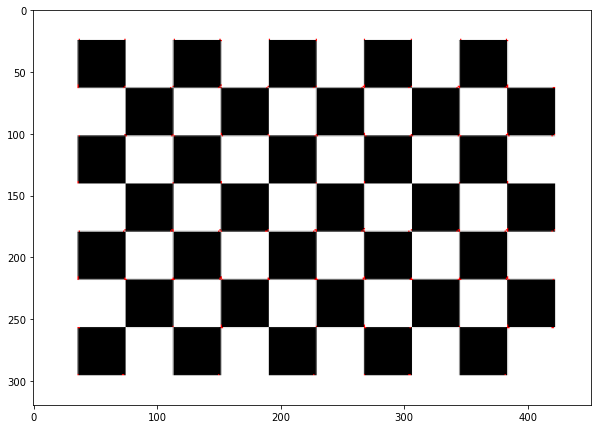

In [14]:
S = 0
imageCol =cv.imread('image2.png')
imageCol[R>S] = [255,0,0]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(imageCol)

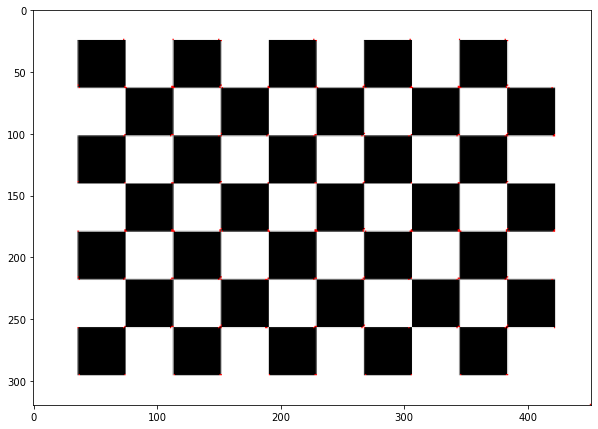

In [15]:
S = 0
imageCol =cv.imread('image2.png')
imageCol[RTriggs>S] = [255,0,0]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(imageCol)

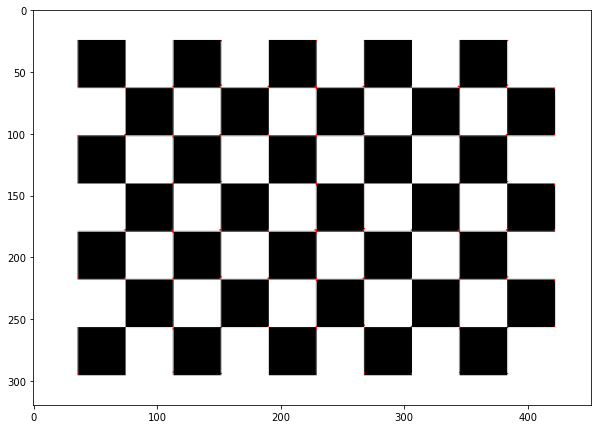

In [16]:
S = 0
imageCol =cv.imread('image2.png')
imageCol[RSzeliski>S] = [255,0,0]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(imageCol)

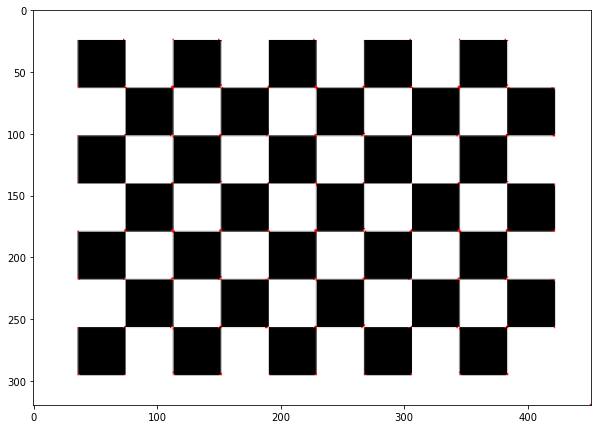

In [17]:
S = 0
imageCol =cv.imread('image2.png')
imageCol[RShiTomasi>S] = [255,0,0]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(imageCol)

comparer avec opencv

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


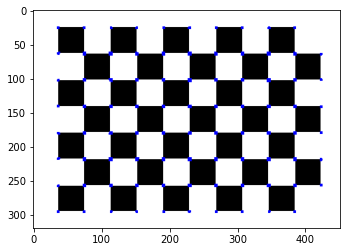

In [18]:
img = np.float32(image)
# Detecter les points avec Harris
dst = cv.cornerHarris(img,2,3,0.06)
# Dilater l'image pour mieux visualiser les points de coins
dst = cv.dilate(dst,None)
# Créer une image RVB
img2=np.zeros((img.shape[0],img.shape[1],3))
img2[:,:,0]=img
img2[:,:,1]=img
img2[:,:,2]=img
# Dessiner les points sur l'image RVB
img2[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(img2)

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 10 Decembre 2021 à 23:00


In [ ]:
# bonne chance